<a href="https://colab.research.google.com/github/MSG-1999/MLOps-MahekGadiya-M25CSA011/blob/Worksheet_1/Lab_1_Mahek_Gadiya_M25CSA011.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install wandb torchvision thop

In [23]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import wandb
from thop import profile

In [24]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [25]:

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


Wand login

In [26]:
wandb.login()

True

In [27]:
wandb.init(
    project="Mlops_Lab_2",
    name="resnet18_final",
    config={
        "dataset": "CIFAR-10",
        "model": "ResNet18",
        "epochs": 25,
        "batch_size": 128,
        "learning_rate": 0.001,
        "optimizer": "Adam",
        "seed": 42
    }
)

#Custom  

In [28]:
class CustomCIFAR10(Dataset):
    def __init__(self, train=True, transform=None):
        self.transform = transform
        self.dataset = torchvision.datasets.CIFAR10(
            root="./data",
            train=train,
            download=True
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

DataLoaders

In [29]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

base_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True
)

num_samples = len(base_dataset)
indices = np.random.permutation(num_samples)

split = int(0.8 * num_samples)

train_idx = indices[:split]
val_idx   = indices[split:]

train_dataset = Subset(
    CustomCIFAR10(train=True, transform=train_transform),
    train_idx
)

val_dataset = Subset(
    CustomCIFAR10(train=True, transform=eval_transform),
    val_idx
)

test_dataset = CustomCIFAR10(
    train=False,
    transform=eval_transform
)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

Train size: 40000
Val size: 10000
Test size: 10000


#Model (ResNet-18)

In [30]:
model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(512, 10)

model = model.to(device)

FLOPs & Parameter Count

In [31]:
dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(dummy_input,), verbose=False)

print(f"FLOPs: {flops/1e6:.2f} MFLOPs")
print(f"Params: {params/1e6:.2f} Million")

wandb.log({
    "FLOPs (MFLOPs)": flops / 1e6,
    "Parameters (Millions)": params / 1e6
})

FLOPs: 557.89 MFLOPs
Params: 11.17 Million


#Loss & Optimizer

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Gradient Flow Visualization

In [33]:
def plot_gradient_flow(named_parameters):
    ave_grads = []
    layers = []

    for n, p in named_parameters:
        if p.requires_grad and p.grad is not None:
            layers.append(n)
            ave_grads.append(
                p.grad.abs().mean().detach().cpu().numpy()
            )

    fig = plt.figure(figsize=(10,5))
    plt.plot(ave_grads)
    plt.xticks(range(len(layers)), layers, rotation="vertical")
    plt.xlabel("Layers")
    plt.ylabel("Average Gradient")
    plt.title("Gradient Flow")
    plt.tight_layout()
    return fig

#Weight Update Flow diagram


In [34]:
def plot_weight_update_flow(model, old_params):
    updates = []
    layers = []

    for (name, param), old_param in zip(model.named_parameters(), old_params):
        layers.append(name)
        updates.append(
            (param - old_param).abs().mean().detach().cpu().numpy()
        )

    fig = plt.figure(figsize=(10,5))
    plt.plot(updates)
    plt.xticks(range(len(layers)), layers, rotation="vertical")
    plt.xlabel("Layers")
    plt.ylabel("Mean Weight Update")
    plt.title("Weight Update Flow")
    plt.tight_layout()
    return fig

#Evaluation Function

In [35]:
def evaluate(model, loader):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item()
            _, pred = out.max(1)
            total += y.size(0)
            correct += pred.eq(y).sum().item()
    return loss_sum / len(loader), 100. * correct / total


#Training (30 Epochs)

In [36]:
# ---- Metric storage (must exist before loop) so that we can plot the Accuarcy a----
train_losses = []
val_losses = []
train_accs = []
val_accs = []

epochs = 30

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    # Saving old parameters for weight update flow
    old_params = [p.clone().detach() for p in model.parameters()]

    # -------- Training --------
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = out.max(1)
        total += y.size(0)
        correct += pred.eq(y).sum().item()

    # -------- Metrics --------
    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total
    val_loss, val_acc = evaluate(model, val_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    # Append AFTER computation (IMPORTANT)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # -------- Visualizations --------
    grad_fig = plot_gradient_flow(model.named_parameters())
    weight_fig = plot_weight_update_flow(model, old_params)

    # -------- W&B Logging --------
    wandb.log({
        "Epoch": epoch + 1,
        "Train Loss": train_loss,
        "Train Accuracy": train_acc,
        "Validation Loss": val_loss,
        "Validation Accuracy": val_acc,
        "Test Accuracy": test_acc,
        "Gradient Flow": wandb.Image(grad_fig),
        "Weight Update Flow": wandb.Image(weight_fig)
    })

    plt.close("all")

    # -------- Console Output (your requested format) --------
    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Train Acc: {train_acc:.2f}% | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Acc: {val_acc:.2f}% | "
        f"Val Loss: {val_loss:.4f}"
    )

# -------- Final Test Accuracy --------
print(f"\nFinal Test Acc: {test_acc:.2f}%")




Epoch [1/30] | Train Acc: 47.60% | Train Loss: 1.4295 | Val Acc: 55.40% | Val Loss: 1.2937
Epoch [2/30] | Train Acc: 65.53% | Train Loss: 0.9610 | Val Acc: 71.04% | Val Loss: 0.8253
Epoch [3/30] | Train Acc: 73.39% | Train Loss: 0.7532 | Val Acc: 74.64% | Val Loss: 0.7403
Epoch [4/30] | Train Acc: 77.86% | Train Loss: 0.6360 | Val Acc: 76.75% | Val Loss: 0.6862
Epoch [5/30] | Train Acc: 80.64% | Train Loss: 0.5594 | Val Acc: 78.48% | Val Loss: 0.6430
Epoch [6/30] | Train Acc: 82.62% | Train Loss: 0.4999 | Val Acc: 80.72% | Val Loss: 0.5739
Epoch [7/30] | Train Acc: 84.50% | Train Loss: 0.4497 | Val Acc: 83.05% | Val Loss: 0.5061
Epoch [8/30] | Train Acc: 85.70% | Train Loss: 0.4123 | Val Acc: 83.96% | Val Loss: 0.4732
Epoch [9/30] | Train Acc: 87.00% | Train Loss: 0.3716 | Val Acc: 85.04% | Val Loss: 0.4551
Epoch [10/30] | Train Acc: 88.11% | Train Loss: 0.3419 | Val Acc: 84.90% | Val Loss: 0.4630
Epoch [11/30] | Train Acc: 88.83% | Train Loss: 0.3181 | Val Acc: 85.15% | Val Loss: 0.46

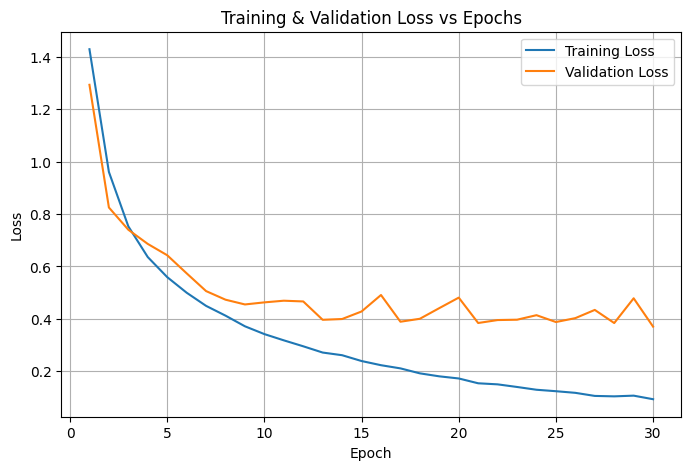

In [37]:
# Epoch range
epochs_range = range(1, epochs + 1)

# -------- Loss vs Epoch --------
loss_fig = plt.figure(figsize=(8,5))
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss vs Epochs")
plt.legend()
plt.grid(True)

# Log to wandb
wandb.log({
    "Loss Curve": wandb.Image(loss_fig)
})

plt.show()


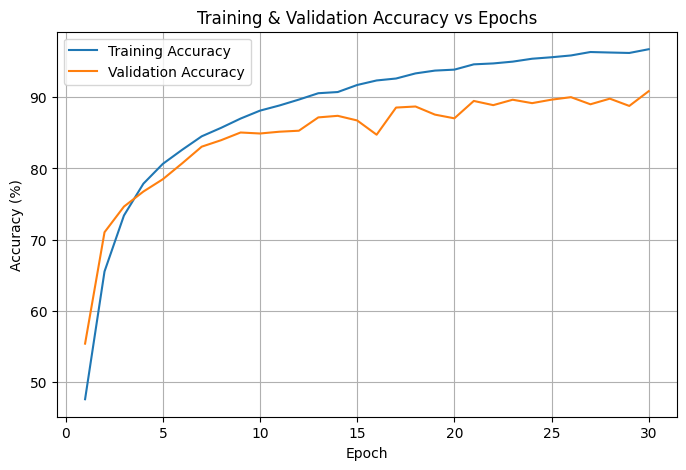

In [38]:
# -------- Accuracy vs Epoch --------
acc_fig = plt.figure(figsize=(8,5))
plt.plot(epochs_range, train_accs, label="Training Accuracy")
plt.plot(epochs_range, val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)

# Log to wandb
wandb.log({
    "Accuracy Curve": wandb.Image(acc_fig)
})

plt.show()


In [39]:
wandb.finish()


Epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
FLOPs (MFLOPs),▁
Parameters (Millions),▁
Test Accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇██▇▇██████████
Train Accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████████████
Train Loss,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇██▇▇██████████
Validation Loss,█▄▄▃▃▃▂▂▂▂▂▂▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▂▁
Epoch,30
FLOPs (MFLOPs),557.88902
Parameters (Millions),11.17396
